##RNN

#Download shakespeare dataset


In [ ]:
!pip install -q tensorflow-gpu==2.0.0
import tensorflow as tf

import numpy as np
import os
import time

import pickle

%matplotlib inline
import matplotlib.pyplot as plt

     |████████████████████████████████| 380.8 MB 33 kB/s 
     |████████████████████████████████| 449 kB 54.5 MB/s 
     |████████████████████████████████| 3.8 MB 54.4 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.0.2 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 2.0.1 which is incompatible.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
# 읽은 다음 파이썬 2와 호환되도록 디코딩
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# 텍스트의 길이는 그 안에 있는 문자의 수
print ('텍스트의 길이: {}자'.format(len(text)))

텍스트의 길이: 1115394자


In [ ]:
# 파일의 unique character의 갯수를 출력합니다. 
vocab = sorted(set(text))
print ('The number of unique characters: {}'.format(len(vocab)))

The number of unique characters: 65


In [ ]:
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [ ]:
print(text[400:600])

be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us 


In [ ]:
print(text[1000:1200])

Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the commonalty.

Second Citizen:
Consider you what services he has done for his country?


# Design a vanila RNN architecture

훈련 전 텍스트 처리

In [ ]:
# Unique character에서 index로 매핑 생성

char2idx = {u:i for i, u in enumerate(vocab)} # character를 index로 변환하는 사전
idx2char = np.array(vocab) # Index를 character로 변환하는 사전

text_as_int = np.array([char2idx[c] for c in text])

In [ ]:
# 각 문자에 대한 정수 표현 생성

print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


필요한 함수 및 Layers

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
    
    batch_size = y.shape[0]

    cross_entropy = np.log(y[np.arange(batch_size), t] + 1e-7)
    loss = -np.sum(cross_entropy) / batch_size
    
    return loss

# 데이터 전처리 함수
def preprocess(text):
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    for word in words:
        if word not in word_to_id:
            new_id =  len(word_to_id)
            word_to_id[word] = new_id
            
    id_to_word = {id_: word for word, id_ in word_to_id.items()}
    
    corpus = np.array([word_to_id[word] for word in words])
    return corpus, word_to_id, id_to_word

In [ ]:
# Layers

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        self.grads[0][...] = dW  
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        W, b = self.params
        out = np.matmul(x, W) + b
        self.x = x
        return out
    
    def backward(self, dout):
        W, b = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        db = np.sum(dout, axis=0)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx
        

class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        if self.t.size == self.y.size:
            self.t = self.t. argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx /= batch_size

        return dx


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

RNN class

In [ ]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None  # 역전파에 사용할 중간 데이터

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)  # tanh 미분
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)  # shape: (H, N) x (N, H) = (H, H)
        dh_prev = np.dot(dt, Wh.T)  # shape: (N, H) x (H, H) = (N, H)
        dWx = np.dot(x.T, dt)  # shape: (D, N) x (N, H) = (D, H)
        dx = np.dot(dt, Wx.T)  # shape: (N, H) x (H, D) = (N, D)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

Time RNN class 구현

In [ ]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # RNN 계층을 리스트로 저장
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h): # hidden state 설정
        self.h = h
    
    def reset_state(self):  # hidden state 초기화
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N(batch), T(time steps), D(input size)
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 합산된 기울기
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

Time Embedding class 구현

In [ ]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    def forward(self, xs):
        N, T = xs.shape  # N(batch), T(timesteps)
        V, D = self.W.shape  # V(vocab_size), D(embedding_size)
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
        
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
            
        self.grads[0][...] = grad
        return None

TimeAffine 클래스 구현

In [ ]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

Time Softmax with Loss class 구현

In [ ]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        if ts.ndim == 3:  # 정답 레이블이 one hot 벡터인 경우
            ts = ts.argmax(axis=2)
        
        mask = (ts != self.ignore_label)
        
        # 배치용과 시계열용을 정리
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)
        
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()
        
        self.cache = (ts, ys, mask, (N, T, V))
        return loss
    
    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기 0으로 설정
        dx = dx.reshape((N, T, V))
        
        return dx

Vanila RNN 구현

In [ ]:
class Vanila_RNN:
  
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화 (Xavier initialization)
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss        

    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

Adam Optimizer

In [ ]:
class ADAM:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in  range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])

            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

Vanila RNN 학습 코드

Epoch 1 , Perplexity : 27983.71
Epoch 2 , Perplexity : 12852.87
Epoch 3 , Perplexity : 8585.17
Epoch 4 , Perplexity : 5487.90
Epoch 5 , Perplexity : 5130.09
Epoch 6 , Perplexity : 4103.37
Epoch 7 , Perplexity : 3331.38
Epoch 8 , Perplexity : 2830.92
Epoch 9 , Perplexity : 2177.14
Epoch 10 , Perplexity : 1809.53
Epoch 11 , Perplexity : 1394.74
Epoch 12 , Perplexity : 1139.97
Epoch 13 , Perplexity : 994.30
Epoch 14 , Perplexity : 843.54
Epoch 15 , Perplexity : 726.93
Epoch 16 , Perplexity : 619.07
Epoch 17 , Perplexity : 532.54
Epoch 18 , Perplexity : 458.00
Epoch 19 , Perplexity : 382.41
Epoch 20 , Perplexity : 343.81
Epoch 21 , Perplexity : 322.03
Epoch 22 , Perplexity : 281.24
Epoch 23 , Perplexity : 255.81
Epoch 24 , Perplexity : 233.37
Epoch 25 , Perplexity : 218.35
Epoch 26 , Perplexity : 195.36
Epoch 27 , Perplexity : 187.79
Epoch 28 , Perplexity : 169.87
Epoch 29 , Perplexity : 155.26
Epoch 30 , Perplexity : 143.85


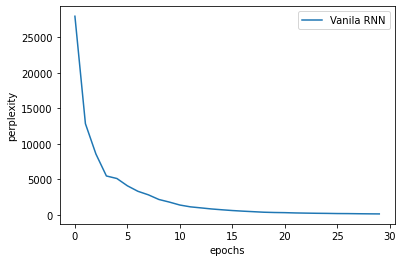

In [ ]:
# Vanila RNN Training code

# 하이퍼파라미터 설정
batch_size = 64
wordvec_size = 64  
hidden_size = 128  # RNN의 은닉 상태 벡터의 원소 수
time_size = 200     # 한 번에 펼치는 시간 크기
lr = 0.04
max_epoch = 30

# 학습 데이터 읽기(전체)

corpus, word_to_id, id_to_word = preprocess(text)
corpus_size = len(corpus)
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = Vanila_RNN(vocab_size, wordvec_size, hidden_size)
optimizer = ADAM(lr)

# mini-batch의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # Epoch 마다 Perplexity 평가
    ppl = np.exp(total_loss / loss_count)
    print('Epoch %d , Perplexity : %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(max_epoch)
plt.plot(x, ppl_list, label='Vanila RNN')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.legend()
plt.show()

In [ ]:
# Report the number of model parameters (Vanila RNN)

def get_n_params(model):
  pp=0
  for p in list(model.params):
    nn=1
    for s in list(p.shape):
      nn = nn * s
    pp += nn
  return pp

print("The number of model(Vanila RNN) parameters : {}".format(get_n_params(model)))

The number of model(Vanila RNN) parameters : 7553634


#Design LSTM architecture

LSTM class

In [ ]:
#LSTM

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i  # Ct
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f
        
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev


Time LSTM

In [ ]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

BaseModel

In [ ]:
class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if not file_name:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if not file_name:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]

LSTM architecture class 구현

In [ ]:
class LSTM_arch(BaseModel):
    def __init__(self, vocab_size=39010, wordvec_size=64, hidden_size=128):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

LSTM 학습 코드

Epoch 1 , Perplexity : 11406.28
Epoch 2 , Perplexity : 3685.51
Epoch 3 , Perplexity : 2365.05
Epoch 4 , Perplexity : 1835.98
Epoch 5 , Perplexity : 1283.74
Epoch 6 , Perplexity : 835.57
Epoch 7 , Perplexity : 535.44
Epoch 8 , Perplexity : 344.13
Epoch 9 , Perplexity : 229.30
Epoch 10 , Perplexity : 160.28
Epoch 11 , Perplexity : 116.56
Epoch 12 , Perplexity : 89.26
Epoch 13 , Perplexity : 70.46
Epoch 14 , Perplexity : 57.15
Epoch 15 , Perplexity : 46.98
Epoch 16 , Perplexity : 39.84
Epoch 17 , Perplexity : 34.34
Epoch 18 , Perplexity : 30.32
Epoch 19 , Perplexity : 27.46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 20 , Perplexity : 24.56
Epoch 21 , Perplexity : 21.98
Epoch 22 , Perplexity : 20.03
Epoch 23 , Perplexity : 18.67
Epoch 24 , Perplexity : 17.55
Epoch 25 , Perplexity : 16.54
Epoch 26 , Perplexity : 15.93
Epoch 27 , Perplexity : 14.77
Epoch 28 , Perplexity : 13.82
Epoch 29 , Perplexity : 12.55
Epoch 30 , Perplexity : 11.36


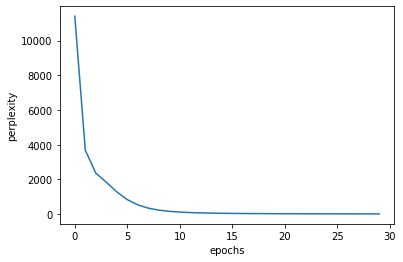

In [ ]:
# LSTM Training code

# 하이퍼파라미터 설정
batch_size = 64
wordvec_size = 64  # input embedding size 
hidden_size = 128  # RNN의 은닉 상태 벡터의 원소 수
time_size = 200     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.04
max_epoch = 30

# 학습 데이터 읽기(전체)

corpus, word_to_id, id_to_word = preprocess(text)
corpus_size = len(corpus)
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list_LSTM = []

# 모델 생성
model_LSTM = LSTM_arch(vocab_size, wordvec_size, hidden_size)
optimizer_LSTM = ADAM(lr)

# mini-batch의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model_LSTM.forward(batch_x, batch_t)
        model_LSTM.backward()
        optimizer_LSTM.update(model_LSTM.params, model_LSTM.grads)
        total_loss += loss
        loss_count += 1

    # Epoch 마다 Perplexity 평가
    ppl_LSTM = np.exp(total_loss / loss_count)
    print('Epoch %d , Perplexity : %.2f'
          % (epoch+1, ppl_LSTM))
    ppl_list_LSTM.append(float(ppl_LSTM))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(max_epoch)
plt.plot(x, ppl_list_LSTM, label='LSTM')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

# 매개변수 저장
model_LSTM.save_params()

In [ ]:
# Report the number of model parameters (LSTM)

def get_n_params(model):
  pp=0
  for p in list(model.params):
    nn=1
    for s in list(p.shape):
      nn = nn * s
    pp += nn
  return pp

print("The number of model(LSTM) parameters : {}".format(get_n_params(model_LSTM)))

The number of model(LSTM) parameters : 7627746


Vanila Rnn과 LSTM perplexity 비교

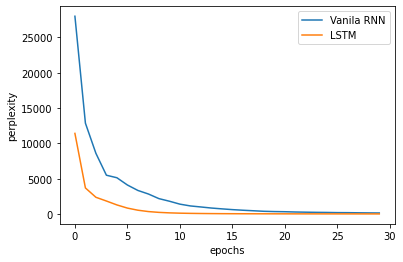

In [ ]:
x = np.arange(max_epoch)
plt.plot(x, ppl_list, label='Vanila RNN')
plt.plot(x, ppl_list_LSTM, label='LSTM')

plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.legend()
plt.show()

#Generate Text


In [ ]:
class RnnlmGen(LSTM_arch):
    def generate(self, start_id, skip_ids=None, sample_size= 100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids
    
    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)
        

In [ ]:
corpus, word_to_id, id_to_word = preprocess(text)
corpus_size = len(corpus)
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

model = RnnlmGen()
model.load_params('./LSTM_arch.pkl')

(1) 'We are'

In [ ]:
model.reset_state()

start_words = 'We are'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1])
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)


--------------------------------------------------
We are accounted which I'ld revolt to that must
Be hostages for gentlemen I never but out o' door:
A most intelligencing posting on the foolish throngs come, sit upon knowledge . Come, know again,
Being ne'er put'st back yesterday, bid that mean: so, go, prepare to do it;
He says, sweet .
This, by the parlor fire .

PETRUCHIO:
Go fetch thee .

JULIET:
O think'st thou not to the world that
good Christians ought to wish thou wilt be forced?
I shame to know her husband;
And when she is
The queen of Margaret's curse,
Nor mother, wife, nor all so not were a dream .

BRAKENBURY:
No marvel, my lord, soon forgot that he


(2) 'what'

In [ ]:
model.reset_state()

start_word = 'what'
start_id = word_to_id[start_word]

# 문장 생성
word_ids = model.generate(start_id)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

--------------------------------------------------
what cares since last I'ld spur to God's!

HASTINGS:
My hair than thy bold waves tremble,
Yea, his hands, with a house to bed,
Which heavy sorrow in the Lords of Ross, Beaumond, and poking-sticks of arts,
I am content .

KATHARINA:
Are you dance .
Thou wouldst swallow .
Yonder's the liberty
of the clouds, this amongst the night before he is content:
The warlike service and patience,
That had not steal'?

LUCIO:
Ay, that made thee murder and Marcius; and split thy skill to undertake to behold
Our friar, king of
England and unnatural,
This deadly quarrel such crimson tempest sing,
Yet see that Edward is given the husband,
And how we long studying at I say,


(3) 'You'

In [ ]:
model.reset_state()

start_word = 'You'
start_id = word_to_id[start_word]

# 문장 생성
word_ids = model.generate(start_id)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


--------------------------------------------------
You wound thee full .
We have strew'd it from their heads of heaven, King daily bloody wrong in blood .

LORD ROSS:
The Earl of Wiltshire's blood,
Whom I encounter'd as wert thou well return and name of this treason
Even with the aims knaves and why cease it in his face?

ESCALUS:
Why, no event .

EDWARD:
'Tis even so I deny:
God pardon and sway till the dove;
She death's true death a woman's hide!
How couldst thou spur a butterfly;
yet your moody discontented souls
Do through the age
Is she was complaint
Intended 'gainst the caparison:
Hadst thou beheld--

MARCIUS:
Pray now, no knavery! See, to my brother, for your veins,
On pain I rise


(4) 'I tell you, friends'

In [ ]:
model.reset_state()

start_words = 'I tell you, friends'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1])
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

--------------------------------------------------
I tell you, friends no little babe,
I'll show't the people, when 'tis a Caesar came and of thee . Fare you had,
The thought to London,
To see thee, fond boy,
If I may find occasion to curse
Abides in discourse
And when I call a pedigree
Of threescore and that dishonour'd .

KING EDWARD IV:
Is proclamation made, but sit in the king that flatter'd thee?
Where be married o'Sunday .

GREMIO:
Was ever match from such safety finds
The trembling seem .

ROMEO:
Give me my back,
To bear thee good:
Trust to't, bethink you; thou hast made time of such a day i' the great chamber with his father's death;
It were to know not
wherefore: so behind
